In [2]:
!pip3 install continuum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.9/521.9 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.7 MB/s eta 0:0

In [4]:
import torch
import torch.nn as nn
import torch.distributions as dist
import torch.optim as optim

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior={'w_mean': 0.0, 'w_std': 1.0, 'b_mean': 0.0, 'b_std': 1.0}):
        super(BayesianLinear, self).__init__()

        self.prior_weight = dist.Normal(prior['w_mean'], prior['w_std'])
        self.prior_bias = dist.Normal(prior['b_mean'], prior['b_std'])
        self.weight_mu = nn.Parameter(torch.full((out_features, in_features), prior['w_mean']))
        self.weight_log_var = nn.Parameter(torch.full((out_features, in_features), prior['w_std']))
        self.bias_mu = nn.Parameter(torch.full((out_features,), prior['b_mean']))
        self.bias_log_var = nn.Parameter(torch.full((out_features,), prior['b_std']))

    def forward(self, x):
        # Sample weights and biases
        weight_sigma = torch.exp(0.5 * self.weight_log_var)
        bias_sigma = torch.exp(0.5 * self.bias_log_var)

        weight_distribution = dist.Normal(self.weight_mu, weight_sigma)
        bias_distribution = dist.Normal(self.bias_mu, bias_sigma)

        weights = weight_distribution.rsample()
        biases = bias_distribution.rsample()

        # Compute output
        return torch.matmul(x, weights.t()) + biases

    def kl_divergence(self):
        # Compute KL divergence between posterior and prior
        weight_sigma = torch.exp(0.5 * self.weight_log_var)
        bias_sigma = torch.exp(0.5 * self.bias_log_var)

        posterior_weight = dist.Normal(self.weight_mu, weight_sigma)
        posterior_bias = dist.Normal(self.bias_mu, bias_sigma)

        kl_div_weights = dist.kl_divergence(posterior_weight, self.prior_weight).sum()
        kl_div_biases = dist.kl_divergence(posterior_bias, self.prior_bias).sum()

        return kl_div_weights + kl_div_biases


class BNNMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BNNMLP, self).__init__()
        self.layer1 = BayesianLinear(input_dim, hidden_dim)
        self.layer2 = BayesianLinear(hidden_dim, hidden_dim)
        self.output_layer = BayesianLinear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

    def kl_divergence(self):
        # Sum KL divergence for all layers
        return self.layer1.kl_divergence() + self.layer2.kl_divergence() + self.output_layer.kl_divergence()

if __name__ == '__main__':
    # Test the model
    x_train = torch.randn(100, 10)  # 100 samples, 10 features
    y_train = torch.randint(0, 2, (100,))  # Binary classification (labels: 0 or 1)

    # Hyperparameters
    input_dim = 10
    hidden_dim = 50
    output_dim = 2
    num_epochs = 50
    batch_size = 16
    learning_rate = 1e-3
    beta = 1.0  # KL divergence scaling factor

    # Model, optimizer, and loss function
    bnn = BNNMLP(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(bnn.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        bnn.train()
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = bnn(x_batch)
            nll_loss = criterion(outputs, y_batch)
            kl_div = bnn.kl_divergence()

            # Total loss
            loss = nll_loss + beta * kl_div

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    print("Training complete!")


Epoch [1/50], Loss: 1136.7843
Epoch [2/50], Loss: 1201.3766
Epoch [3/50], Loss: 1395.0464
Epoch [4/50], Loss: 1820.4495
Epoch [5/50], Loss: 1089.7579
Epoch [6/50], Loss: 1415.1250
Epoch [7/50], Loss: 1070.2705
Epoch [8/50], Loss: 1418.2506
Epoch [9/50], Loss: 2003.9702
Epoch [10/50], Loss: 1213.4784
Epoch [11/50], Loss: 1532.6980
Epoch [12/50], Loss: 1031.3303
Epoch [13/50], Loss: 1015.7167
Epoch [14/50], Loss: 1308.4971
Epoch [15/50], Loss: 1033.6564
Epoch [16/50], Loss: 1243.2509
Epoch [17/50], Loss: 1417.0719
Epoch [18/50], Loss: 973.7228
Epoch [19/50], Loss: 965.4017
Epoch [20/50], Loss: 1031.9211
Epoch [21/50], Loss: 986.9348
Epoch [22/50], Loss: 1672.0752
Epoch [23/50], Loss: 1137.9651
Epoch [24/50], Loss: 1066.2310
Epoch [25/50], Loss: 917.0609
Epoch [26/50], Loss: 909.2361
Epoch [27/50], Loss: 901.4633
Epoch [28/50], Loss: 1023.2332
Epoch [29/50], Loss: 886.2008
Epoch [30/50], Loss: 1767.9241
Epoch [31/50], Loss: 969.4212
Epoch [32/50], Loss: 1333.1047
Epoch [33/50], Loss: 967.

Training on Task 1/5
Training on Task 2/5
Training on Task 3/5
Training on Task 4/5
Training on Task 5/5


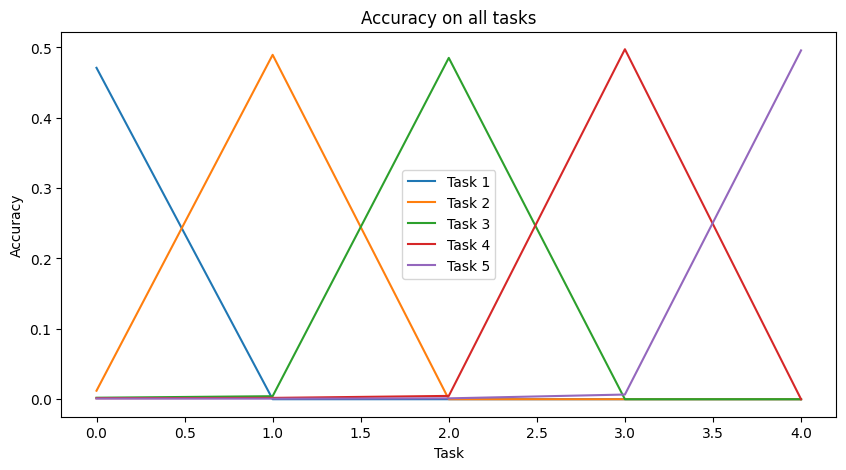

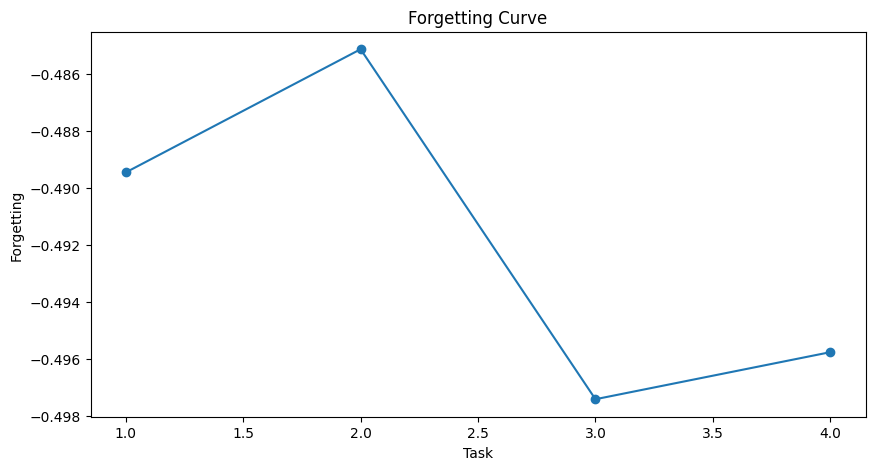

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from continuum import ClassIncremental
from continuum.datasets import MNIST
from continuum.tasks import split_train_val
import matplotlib.pyplot as plt

# Define BayesianLinear and BNNMLP classes as provided in the question

# Incremental Learning Experiment
def run_class_incremental_experiment():
    # Hyperparameters
    input_dim = 28 * 28
    hidden_dim = 256
    output_dim = 10  # Total number of classes in MNIST
    num_epochs = 10
    batch_size = 32
    learning_rate = 1e-3
    beta = 1.0  # KL divergence scaling factor

    # Prepare the dataset using continuum
    dataset = MNIST(data_path="data", download=True, train=True)
    scenario = ClassIncremental(dataset, increment=2)  # Learn 2 classes per task

    # Initialize model, optimizer, and loss function
    bnn = BNNMLP(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(bnn.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Metrics storage
    num_tasks = len(scenario)
    acc_matrix = np.zeros((num_tasks, num_tasks))  # Accuracy matrix

    # Training and evaluation loop
    for t, taskset in enumerate(scenario):
        print(f"Training on Task {t + 1}/{num_tasks}")

        # Prepare task data
        train_taskset, val_taskset = split_train_val(taskset, val_split=0.2)
        train_loader = torch.utils.data.DataLoader(train_taskset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_taskset, batch_size=batch_size, shuffle=False)

        # Train on current task
        for epoch in range(num_epochs):
            bnn.train()
            for batch in train_loader:
                x, y = batch[0], batch[1]
                x = x.view(x.size(0), -1)  # Flatten the input

                # Forward pass
                outputs = bnn(x)
                nll_loss = criterion(outputs, y)
                kl_div = bnn.kl_divergence()

                # Total loss
                loss = nll_loss + beta * kl_div

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Evaluate on all tasks seen so far
        bnn.eval()
        for eval_task in range(t + 1):
            taskset_eval = scenario[eval_task]
            eval_loader = torch.utils.data.DataLoader(taskset_eval, batch_size=batch_size, shuffle=False)

            correct = 0
            total = 0
            with torch.no_grad():
                for batch in eval_loader:
                    x, y = batch[0], batch[1]
                    x = x.view(x.size(0), -1)
                    outputs = bnn(x)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == y).sum().item()
                    total += y.size(0)

            acc_matrix[t, eval_task] = correct / total

    # Compute forgetting metrics
    forgetting = np.zeros(num_tasks)
    for t in range(1, num_tasks):
        forgetting[t] = max(acc_matrix[:t, t]) - acc_matrix[t, t]

    # Plot results
    plot_results(acc_matrix, forgetting)


def plot_results(acc_matrix, forgetting):
    num_tasks = acc_matrix.shape[0]

    # Plot accuracy matrix
    plt.figure(figsize=(10, 5))
    for i in range(num_tasks):
        plt.plot(acc_matrix[i, :], label=f"Task {i+1}")
    plt.title("Accuracy on all tasks")
    plt.xlabel("Task")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Plot forgetting curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_tasks), forgetting[1:], marker="o")
    plt.title("Forgetting Curve")
    plt.xlabel("Task")
    plt.ylabel("Forgetting")
    plt.show()


if __name__ == "__main__":
    run_class_incremental_experiment()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.06MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 65.8kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.52MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Training on Task 1/5
Training on Task 2/5
Training on Task 3/5
Training on Task 4/5
Training on Task 5/5


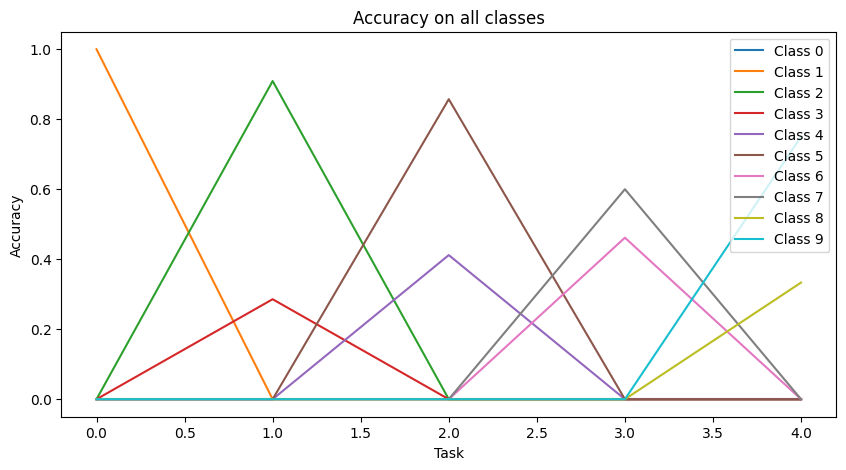

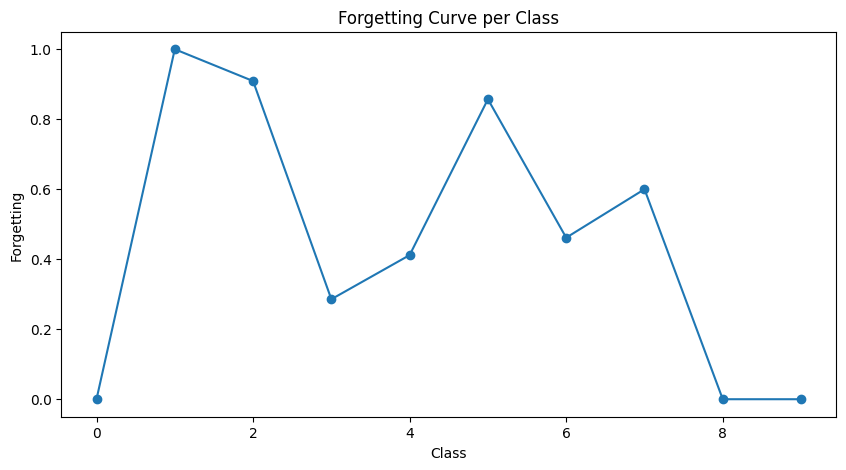

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from continuum import ClassIncremental
from continuum.datasets import MNIST
from continuum.tasks import split_train_val
import matplotlib.pyplot as plt

# Define BayesianLinear and BNNMLP classes as provided in the question

# Incremental Learning Experiment
def run_class_incremental_experiment():
    # Hyperparameters
    input_dim = 28 * 28
    hidden_dim = 256
    output_dim = 10  # Total number of classes in MNIST
    num_epochs = 10
    batch_size = 32
    learning_rate = 1e-3
    beta = 1.0  # KL divergence scaling factor

    # Prepare the dataset using continuum
    dataset = MNIST(data_path="data", download=True, train=True)
    scenario = ClassIncremental(dataset, increment=2)  # Learn 2 classes per task

    # Initialize model, optimizer, and loss function
    bnn = BNNMLP(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(bnn.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Metrics storage
    num_tasks = len(scenario)
    acc_matrix = np.zeros((num_tasks, output_dim))  # Accuracy matrix for all classes

    # Training and evaluation loop
    for t, taskset in enumerate(scenario):
        print(f"Training on Task {t + 1}/{num_tasks}")

        # Prepare task data
        train_taskset, val_taskset = split_train_val(taskset, val_split=0.2)
        train_loader = torch.utils.data.DataLoader(train_taskset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_taskset, batch_size=batch_size, shuffle=False)

        # Train on current task
        for epoch in range(num_epochs):
            bnn.train()
            for batch in train_loader:
                x, y = batch[0], batch[1]
                x = x.view(x.size(0), -1)  # Flatten the input

                # Forward pass
                outputs = bnn(x)
                nll_loss = criterion(outputs, y)
                kl_div = bnn.kl_divergence()

                # Total loss
                loss = nll_loss + beta * kl_div

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Evaluate on all classes seen so far
        bnn.eval()
        for eval_task in range(t + 1):
            taskset_eval = scenario[eval_task]
            eval_loader = torch.utils.data.DataLoader(taskset_eval, batch_size=batch_size, shuffle=False)

            correct = 0
            total = 0
            with torch.no_grad():
                for batch in eval_loader:
                    x, y = batch[0], batch[1]
                    x = x.view(x.size(0), -1)
                    outputs = bnn(x)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == y).sum().item()
                    total += y.size(0)

                # Update class-level accuracy for all seen classes
                for c in range(output_dim):
                    class_correct = (predicted[y == c] == c).sum().item()
                    class_total = (y == c).sum().item()
                    if class_total > 0:
                        acc_matrix[t, c] = class_correct / class_total

    # Compute forgetting metrics for each class
    forgetting = np.zeros(output_dim)
    for c in range(output_dim):
        forgetting[c] = max(acc_matrix[:num_tasks, c]) - acc_matrix[num_tasks - 1, c]

    # Plot results
    plot_results(acc_matrix, forgetting)


def plot_results(acc_matrix, forgetting):
    num_tasks = acc_matrix.shape[0]
    num_classes = acc_matrix.shape[1]

    # Plot accuracy matrix
    plt.figure(figsize=(10, 5))
    for i in range(num_classes):
        plt.plot(acc_matrix[:, i], label=f"Class {i}")
    plt.title("Accuracy on all classes")
    plt.xlabel("Task")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Plot forgetting curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(num_classes), forgetting, marker="o")
    plt.title("Forgetting Curve per Class")
    plt.xlabel("Class")
    plt.ylabel("Forgetting")
    plt.show()


if __name__ == "__main__":
    run_class_incremental_experiment()


In [14]:
!git clone https://github.com/mmasana/FACIL.git


Cloning into 'FACIL'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 159 (delta 49), reused 34 (delta 34), pack-reused 76 (from 1)
Receiving objects: 100% (159/159), 7.63 MiB | 17.13 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [17]:
!cd FACIL

/content/FACIL/src


# 新段落

In [29]:
cd src

/content/FACIL/src


In [30]:
from main_incremental import main

# 如果有自定义参数，可以直接传递
main()


ModuleNotFoundError: No module named 'datasets.data_loader'